In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/MyDrive/Colab/MIPT/CV/HW_1/Bharani_Lightning

/content/drive/MyDrive/Colab/MIPT/CV/HW_1/Bharani_Lightning


In [3]:
# !pip install torchinfo
# !pip install onnx
# !pip install onnxruntime
# !pip install pytorch_lightning
# !pip install -U catalyst
# !pip install --upgrade pytorch-lightning
# !pip install pypng
# !pip install pyyaml

In [4]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import datasets
from collections import defaultdict
from random import choice
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchinfo import summary
from typing import Dict
from contextlib import contextmanager
from sklearn.metrics import accuracy_score
import math
import pytorch_lightning as pl
import catalyst
from catalyst.core.logger import ILogger
from catalyst.loggers.console import ConsoleLogger
from catalyst import dl
import re
import onnxruntime as ort
import pickle
import png
import onnx
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import classification_report
import random
from pathlib import Path
import yaml
import torch.nn.utils.prune as prune

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

Using device:  cuda:0


# MSAI Computer Vision Seminar 02: CNN backbones

# 1. Pytorch CNN implementation

Today we're gonna use modern CNN architecture features to create our own models and train them from scratch.

In [5]:
# 1. Loading CIFAR10 Dataset
# Let's use CIFAR10 dataset for our CNN model development as a small and simple toy dataset.
# It is easy to download it using torchvision.datasets.

train_ds = datasets.CIFAR10("./cifar10", train=True, download=True)
val_ds = datasets.CIFAR10("./cifar10", train=False, download=True)
print(f"Train / val size: {len(train_ds)} / {len(val_ds)}")

# let's see what classes/labels we have and make sure that we have the same classes in train/val parts
num_classes = len(train_ds.classes)
print(f"num_classes: {num_classes}")
print("Training classes: ", train_ds.classes)
print("Validation classes: ", val_ds.classes)

item_label_dict = {k: v for k, v in enumerate(train_ds.classes)}
print(item_label_dict)

Files already downloaded and verified
Files already downloaded and verified
Train / val size: 50000 / 10000
num_classes: 10
Training classes:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Validation classes:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


In [6]:
def sample_from_dataset(dataset):
    class_names = dataset.classes
    num_classes = len(class_names)
    label_to_idx = defaultdict(list)

    for i, sample in enumerate(dataset):
        data, lbl = sample
        label_to_idx[lbl].append(i)

    grid_size = (2, int(num_classes / 2 + 0.5))
    f, axarr = plt.subplots(*grid_size)
    f.set_size_inches(15, 4)
    for lbl in range(num_classes):
        img, _ = dataset[choice(label_to_idx[lbl])]
        sample_title = "%s (label=%d)" % (class_names[lbl], lbl)
        axarr[lbl % grid_size[0], lbl // grid_size[0]].imshow(img)
        axarr[lbl % grid_size[0], lbl // grid_size[0]].set_title(sample_title)
        axarr[lbl % grid_size[0], lbl // grid_size[0]].axis("off")
    return

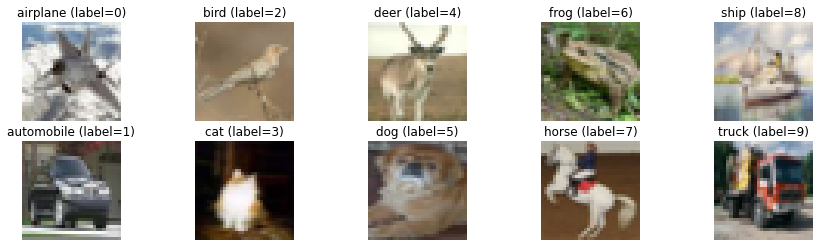

In [7]:
sample_from_dataset(train_ds)

Let's plot some images from the dataset too:

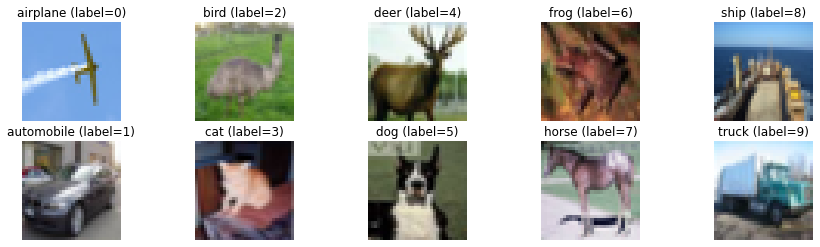

In [8]:
sample_from_dataset(val_ds)

We see that image classes are correct for both training and validation dataset parts, so we can use this dataset in our experiments.


# 2. Data Augmentation and Data Loaders

Image data is needed to be pre-processed before feeding it into any CNN forward pass.

Such pre-processing shall include:
* converting image np.ndarrays / PIL images to torch tensors
* scaling image pixel values from [0;255] to [0;1]
* (optionally) normalizing data by subtracting some mean value and dividing by some std value.

Such pre-processing is done using torchvision.transforms module.
The same module implements different random image perturbations, that can be used for image augmentation during CNN training.

**Question:** name at least 5 image augmentation, that we can apply to image classification task here?

In [9]:
# let's use ImageNet mean and std values for image pixel values
means = np.array((0.4914, 0.4822, 0.4465))
stds = np.array((0.2023, 0.1994, 0.2010))

base_transforms = [transforms.ToTensor(), transforms.Normalize(means, stds)]
augmented_transforms = [
    # add your own augmentations here
    transforms.RandomCrop(32, padding=4, padding_mode="reflect"),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(hue=0.01, brightness=0.3, contrast=0.3, saturation=0.3),
]
augmented_transforms += base_transforms

transform_basic = transforms.Compose(base_transforms)
transform_augment = transforms.Compose(augmented_transforms)

train_ds = datasets.CIFAR10("./cifar10", train=True, download=True, transform=transform_augment)
val_ds = datasets.CIFAR10("./cifar10", train=False, download=True, transform=transform_basic)

batch_size = 256
train_batch_gen = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_batch_gen = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
img_batch, label_batch = next(iter(train_batch_gen))
print(f"Label tensor size =  {label_batch.size()}")
print(f"Batch tensor size [B, C, H, W] = {img_batch.size()}")
print(f"Batch tensor range: min = {img_batch.min().item():.4f} max = {img_batch.max().item():.4f} ")

Files already downloaded and verified
Files already downloaded and verified
Label tensor size =  torch.Size([256])
Batch tensor size [B, C, H, W] = torch.Size([256, 3, 32, 32])
Batch tensor range: min = -2.4291 max = 2.7537 


In [10]:
def sample_from_generator(batch_gen):
    data_batch, label_batch = next(iter(batch_gen))
    grid_size = (3, 3)
    f, axarr = plt.subplots(*grid_size)
    f.set_size_inches(15, 10)
    class_names = batch_gen.dataset.classes
    for i in range(grid_size[0] * grid_size[1]):

        # read images from batch to numpy.ndarray and change axes order [H, W, C] -> [H, W, C]
        batch_image_ndarray = np.transpose(data_batch[i].numpy(), [1, 2, 0])

        # inverse normalization for image data values back to [0,1]
        # and clipping the values for correct pyplot.imshow()
        src = np.clip(stds * batch_image_ndarray + means, 0, 1)

        # display batch samples with labels
        sample_title = "%s (%d)" % (class_names[label_batch[i]], label_batch[i])
        axarr[i // grid_size[0], i % grid_size[0]].imshow(src)
        axarr[i // grid_size[0], i % grid_size[0]].set_title(sample_title)
    return

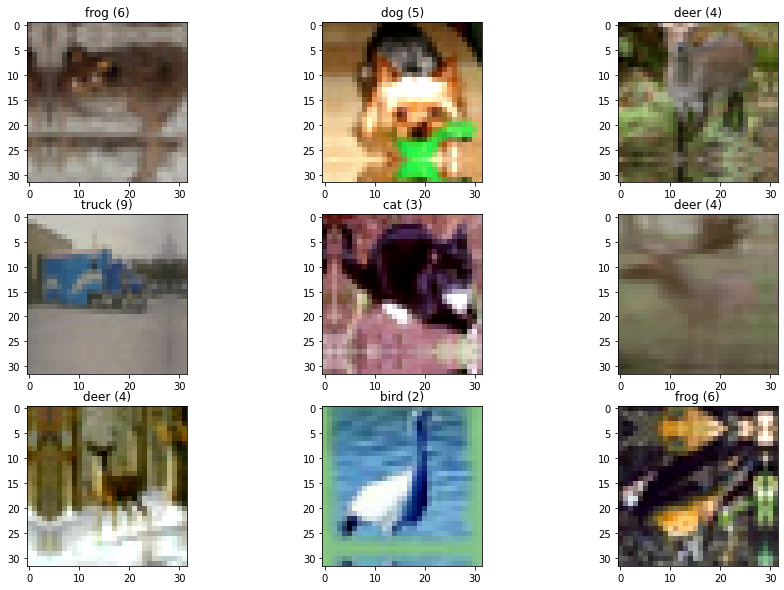

In [11]:
sample_from_generator(train_batch_gen)

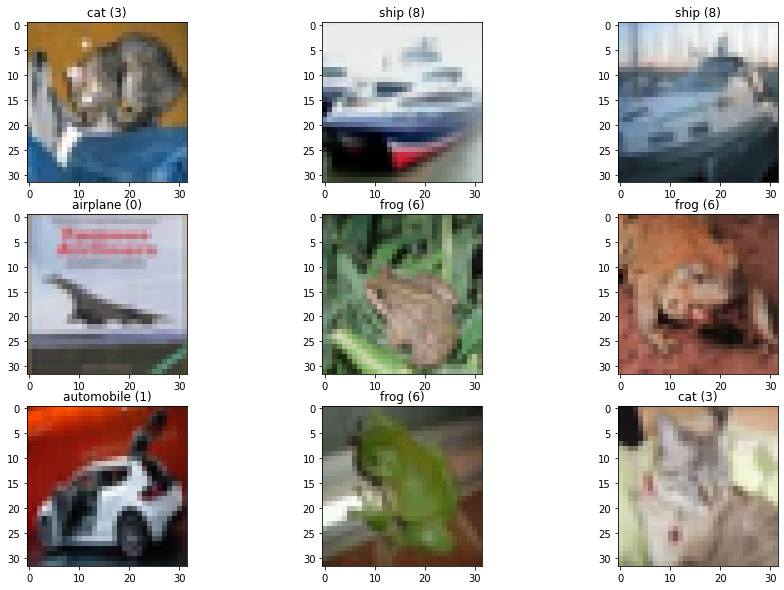

In [12]:
sample_from_generator(val_batch_gen)

# 3. Baseline Model Implementation and CNN Training

Let's review the implementation of base layers for several models, that were discussed during the lecture: ResNet, DenseNet, SE Blocks etc.


Let's use __Catalyst__ library to simplify CNN training, validation and checkpointing.

Below we implement custom `ILogger` ([see docs](https://catalyst-team.github.io/catalyst/api/core.html#catalyst.core.logger.ILogger)), the class providing information to user during training.

In fact it is replica of `catalyst.loggers.console.ConsoleLogger`, see [docs here](https://catalyst-team.github.io/catalyst/api/loggers.html#catalyst.loggers.console.ConsoleLogger)

We also need some validation code to reload the best checkpoint, evaluate it using our validation data and compute metrics.

In [18]:
############### model #############

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(
            in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=False
        )
        self.relu = nn.LeakyReLU() 
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, in_tensor):
        out = self.conv(in_tensor)
        out = self.relu(self.bn(out))
        return out


class BaseModel(nn.Module):
    def __init__(self, num_classes):
        super(BaseModel, self).__init__()
        self.num_classes = num_classes
        self.in_preproc = nn.Sequential(ConvBlock(3, 64), nn.MaxPool2d((2, 2)))
        self.features = nn.Sequential(
            ConvBlock(64, 64),
            ConvBlock(64, 64),
            nn.MaxPool2d((2, 2)),
            ConvBlock(64, 128),
            ConvBlock(128, 128),
            nn.MaxPool2d((2, 2)),
            ConvBlock(128, 128),
            nn.AdaptiveAvgPool2d(1),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.25),
            nn.Linear(128, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, self.num_classes),
        )
    def forward(self, in_tensor):
        x = self.in_preproc(in_tensor)
        x = self.features(x)
        feat = torch.flatten(x, 1)
        logits = self.classifier(feat)
        return logits 

############### model summary #############

def cifar_model_summary(model, device):
    col_names = ("output_size", "output_size", "num_params", "mult_adds")
    return summary(model, (1, 3, 32, 32), device=device, col_names=col_names)

num_classes = len(train_ds.classes)
print(cifar_model_summary(BaseModel(num_classes), device))

############## catalyst runner and loggert#############

def _format_metrics(dct: Dict):
    return " | ".join([f"{k}: {float(dct[k]):.03}" for k in sorted(dct.keys())])


class CustomLogger(ConsoleLogger):
    """Custom console logger for parameters and metrics.
    Output the metric into the console during experiment.

    Note:
        We inherit ConsoleLogger to overwrite default Catalyst logging behaviour
    """
    def log_metrics(
        self,
        metrics: Dict[str, float],
        scope: str,
        runner: "IRunner",
    ) -> None:
        """Logs loader and epoch metrics to stdout."""
        if scope == "loader":
            prefix = f"{runner.loader_key} ({runner.epoch_step}/{runner.num_epochs}) "
            msg = prefix + _format_metrics(metrics)
            print(msg)
        elif scope == "epoch":
            # @TODO: remove trick to save pure epoch-based metrics, like lr/momentum
            prefix = f"* Epoch ({runner.epoch_step}/{runner.num_epochs}) "
            msg = prefix + _format_metrics(metrics["_epoch_"])
            print(msg)

runner = dl.SupervisedRunner(
    input_key="img", output_key="logits", target_key="targets", loss_key="loss"
)
loaders = {"train": train_batch_gen, "valid": val_batch_gen}

model = BaseModel(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# model training
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    loaders=loaders,
    loggers={"console": CustomLogger()},
    num_epochs=5,
    callbacks=[
        dl.AccuracyCallback(input_key="logits", target_key="targets", topk=(1, 3, 5)),
    ],
    logdir="./logs_BaseModel",
    valid_loader="valid",
    valid_metric="loss",  # IOU, accuracy, f-score....
    minimize_valid_metric=True,
    verbose=True,
    load_best_on_end=True,
)


############### model quality #############

def load_ckpt(path, model, device=torch.device("cpu")):
    """
    Load saved checkpoint weights to model
    :param path: full path to checkpoint
    :param model: initialized model class nested from nn.Module()
    :param device: base torch device for validation
    :return: model with loaded 'state_dict'
    """
    assert os.path.isfile(path), FileNotFoundError(f"no file: {path}")

    ckpt = torch.load(path, map_location=device)
    # ckpt_dict = ckpt['model_state_dict']
    ckpt_dict = ckpt    
    model_dict = model.state_dict()
    ckpt_dict = {k: v for k, v in ckpt_dict.items() if k in model_dict}
    model_dict.update(ckpt_dict)
    model.load_state_dict(model_dict)
    return model


@torch.no_grad()
def validate_model(model, loader, device):
    """
    Evaluate implemented model
    :param model: initialized model class nested from nn.Module() with loaded state dict
    :param loader batch data loader for evaluation set
    :param device: base torch device for validation
    :return: dict performance metrics
    """
    label_list = []
    pred_list = []
    model.train(False)
    model = model.to(device)

    for data_tensor, lbl_tensor in loader:
        lbl_values = lbl_tensor.cpu().view(-1).tolist()
        label_list.extend(lbl_values)
        logits = model(data_tensor.to(device))
        scores = F.softmax(logits.detach().cpu(), 1).numpy()
        pred_labels = np.argmax(scores, 1)
        pred_list.extend(pred_labels.ravel().tolist())

    labels = np.array(label_list)
    predicted = np.array(pred_list)
    acc = accuracy_score(labels, predicted)
    print(f"model accuracy: {acc:.4f}")
    metric_dict = {"accuracy": acc}
    return metric_dict


ckpt_fp = 'logs_BaseModel/checkpoints/model.best.pth'
mod = model
mod = load_ckpt(ckpt_fp, mod).eval()
new_runner = validate_model(mod, loaders["valid"], device)

############### model onnx and predictions #############

# def to_numpy(tensor):
#     return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# def softmaxx(x):
#     e = np.exp(x)
#     return e / e.sum()

# img_batch_for_pred, label_batch_true = next(iter(val_batch_gen))
# def to_onnx_export(model, dummy_data):
#     text = str(type(model))
#     pattern = re.compile(r"\.\s*(\w+)")
#     b = re.findall(pattern, text)
#     model_name = b[0] + '.' + 'onnx'
#     print(model_name)
#     torch.onnx.export(model, 
#                   dummy_data, 
#                   model_name, 
#                   input_names=['image'], 
#                   output_names=['label'], 
#                   dynamic_axes={'image': {0: 'batch_size'}},
#                   verbose=True)
#     return model_name

# ckpt_fp = 'logs_NiN/checkpoints/model.best.pth'
# mod = BaseModel(num_classes=num_classes)
# model = load_ckpt(ckpt_fp, mod).eval()
# img_batch_for_pred, label_batch_true = next(iter(val_batch_gen))
# dummy_data = img_batch_for_pred
# model_onnx = to_onnx_export(model, dummy_data)

# ort_session = ort.InferenceSession(model_onnx)
# ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(img_batch_for_pred)}
# ort_outs = ort_session.run(None, ort_inputs)
# img_out_y = ort_outs[0]
# print(img_out_y.shape)
# softmaxed_y = softmaxx(img_out_y)
# print(softmaxed_y.shape)
# label_batch_pred = np.argmax(softmaxx(img_out_y), 1)
# acc = accuracy_score(label_batch_true, label_batch_pred)
# print(acc)

Layer (type:depth-idx)                   Output Shape              Output Shape              Param #                   Mult-Adds
BaseModel                                [1, 10]                   [1, 10]                   --                        --
├─Sequential: 1-1                        [1, 64, 16, 16]           [1, 64, 16, 16]           --                        --
│    └─ConvBlock: 2-1                    [1, 64, 32, 32]           [1, 64, 32, 32]           --                        --
│    │    └─Conv2d: 3-1                  [1, 64, 32, 32]           [1, 64, 32, 32]           1,728                     1,769,472
│    │    └─BatchNorm2d: 3-2             [1, 64, 32, 32]           [1, 64, 32, 32]           128                       128
│    │    └─LeakyReLU: 3-3               [1, 64, 32, 32]           [1, 64, 32, 32]           --                        --
│    └─MaxPool2d: 2-2                    [1, 64, 16, 16]           [1, 64, 16, 16]           --                        --
├─Sequent

1/5 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (1/5) accuracy01: 0.467 | accuracy01/std: 0.107 | accuracy03: 0.794 | accuracy03/std: 0.089 | accuracy05: 0.914 | accuracy05/std: 0.055 | loss: 1.45 | loss/mean: 1.45 | loss/std: 0.272 | lr: 0.001 | momentum: 0.9


1/5 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (1/5) accuracy01: 0.565 | accuracy01/std: 0.0299 | accuracy03: 0.866 | accuracy03/std: 0.0234 | accuracy05: 0.952 | accuracy05/std: 0.0139 | loss: 1.18 | loss/mean: 1.18 | loss/std: 0.0682 | lr: 0.001 | momentum: 0.9
* Epoch (1/5) 


2/5 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (2/5) accuracy01: 0.626 | accuracy01/std: 0.0433 | accuracy03: 0.891 | accuracy03/std: 0.0237 | accuracy05: 0.963 | accuracy05/std: 0.0131 | loss: 1.05 | loss/mean: 1.05 | loss/std: 0.101 | lr: 0.001 | momentum: 0.9


2/5 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (2/5) accuracy01: 0.653 | accuracy01/std: 0.0287 | accuracy03: 0.905 | accuracy03/std: 0.0164 | accuracy05: 0.97 | accuracy05/std: 0.01 | loss: 0.97 | loss/mean: 0.97 | loss/std: 0.0708 | lr: 0.001 | momentum: 0.9
* Epoch (2/5) 


3/5 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (3/5) accuracy01: 0.681 | accuracy01/std: 0.031 | accuracy03: 0.916 | accuracy03/std: 0.0187 | accuracy05: 0.975 | accuracy05/std: 0.00984 | loss: 0.894 | loss/mean: 0.894 | loss/std: 0.0747 | lr: 0.001 | momentum: 0.9


3/5 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (3/5) accuracy01: 0.72 | accuracy01/std: 0.0257 | accuracy03: 0.935 | accuracy03/std: 0.0157 | accuracy05: 0.982 | accuracy05/std: 0.00908 | loss: 0.778 | loss/mean: 0.778 | loss/std: 0.0587 | lr: 0.001 | momentum: 0.9
* Epoch (3/5) 


4/5 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (4/5) accuracy01: 0.724 | accuracy01/std: 0.0267 | accuracy03: 0.932 | accuracy03/std: 0.0168 | accuracy05: 0.979 | accuracy05/std: 0.00949 | loss: 0.789 | loss/mean: 0.789 | loss/std: 0.0655 | lr: 0.001 | momentum: 0.9


4/5 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (4/5) accuracy01: 0.74 | accuracy01/std: 0.026 | accuracy03: 0.937 | accuracy03/std: 0.0145 | accuracy05: 0.981 | accuracy05/std: 0.0104 | loss: 0.744 | loss/mean: 0.744 | loss/std: 0.0666 | lr: 0.001 | momentum: 0.9
* Epoch (4/5) 


5/5 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (5/5) accuracy01: 0.753 | accuracy01/std: 0.0287 | accuracy03: 0.944 | accuracy03/std: 0.014 | accuracy05: 0.985 | accuracy05/std: 0.00753 | loss: 0.704 | loss/mean: 0.704 | loss/std: 0.0638 | lr: 0.001 | momentum: 0.9


5/5 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (5/5) accuracy01: 0.767 | accuracy01/std: 0.0232 | accuracy03: 0.949 | accuracy03/std: 0.0138 | accuracy05: 0.987 | accuracy05/std: 0.00682 | loss: 0.664 | loss/mean: 0.664 | loss/std: 0.0642 | lr: 0.001 | momentum: 0.9
* Epoch (5/5) 
Top models:
./logs_BaseModel/checkpoints/model.0005.pth	0.6636
model accuracy: 0.7672


# 4. Implementing More Layers

Let's see how one can implement some state-of-the-art layers, such as residual blocks, densenet dense and transition blocks, etc.
This migh help you when building your CNN model from scratch.

### 4.1 ResNet Implementation

In [ ]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class ResidualBlock(nn.Module):
    def __init__(self, inplanes, planes, stride=1, downsample=None, norm_layer=None):
        super(ResidualBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu1 = nn.LeakyReLU()
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.relu2 = nn.LeakyReLU()
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu2(out)

        return out

In [ ]:
class BaseResNet(nn.Sequential):
    def __init__(self, block: nn.Module, layers, num_classes, norm_layer=None):
        super(BaseResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.layer1 = self._make_layer(block, self.inplanes, layers[0])
        self.layer2 = self._make_layer(block, self.inplanes * 2, layers[1], stride=2)
        self.layer3 = self._make_layer(block, self.inplanes * 4, layers[2], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(nn.Dropout(p=0.3), nn.Linear(self.inplanes, num_classes))

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        norm_layer = self._norm_layer
        downsample = None
        if stride != 1:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes, stride),
                norm_layer(planes),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, norm_layer))
        self.inplanes = planes
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [ ]:
model_resnet = BaseResNet(ResidualBlock, [3, 4, 23, 3], num_classes=num_classes)
cifar_model_summary(model_resnet, device)

### 4.2 DenseNet Implementation

As you remember from the lecture, we need to implement Dense block, which in this notation is called ``Basic``:\

![](https://pytorch.org/assets/images/densenet1.png)
<!-- <img src="dense_concat.gif"> -->

In [ ]:
class DenseBlock(nn.Module):
    def __init__(self, in_planes, growth_rate):
        super(Bottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(4 * growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)
        self.relu1 = nn.LeakyReLU()

    def forward(self, x):
        out = self.conv1(self.bn1(self.relu1(out)))
        out = torch.cat([out, x], 1)
        return out

Another option for Dense block is using ``Bottleneck`` approach, which expands channel number before main convolution operation to increases data dimensionality and simplify class feature separation for convolution.

In [ ]:
class Bottleneck(nn.Module):
    def __init__(self, in_planes, growth_rate):
        super(Bottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, 4 * growth_rate, kernel_size=1, bias=False)
        self.relu1 = nn.LeakyReLU()
        self.bn2 = nn.BatchNorm2d(4 * growth_rate)
        self.conv2 = nn.Conv2d(4 * growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)
        self.relu2 = nn.LeakyReLU()

    def forward(self, x):
        out = self.conv1(self.bn1(self.relu1(x)))
        out = self.conv2(self.bn2(self.relu2(out)))
        out = torch.cat([out, x], 1)
        return out

Another important part of DenseNet model is the ``Transition`` block, which allows to decrease data dimensionality in between different Dense blocks:

In [ ]:
class Transition(nn.Module):
    def __init__(self, in_planes, out_planes):
        super(Transition, self).__init__()
        self.bn = nn.BatchNorm2d(in_planes)
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=1, bias=False)
        self.relu = nn.LeakyReLU()

    def forward(self, x):
        out = self.conv(self.bn(self.relu(x)))
        out = F.avg_pool2d(out, 2)
        return out

In [ ]:
class DenseNet(nn.Module):
    def __init__(self, block, nblocks, growth_rate=12, reduction=0.5, num_classes=10):
        super(DenseNet, self).__init__()
        self.growth_rate = growth_rate

        num_planes = 2 * growth_rate
        self.conv1 = nn.Conv2d(3, num_planes, kernel_size=3, padding=1, bias=False)

        self.dense1 = self._make_dense_layers(block, num_planes, nblocks[0])
        num_planes += nblocks[0] * growth_rate
        out_planes = int(math.floor(num_planes * reduction))
        self.trans1 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense2 = self._make_dense_layers(block, num_planes, nblocks[1])
        num_planes += nblocks[1] * growth_rate
        out_planes = int(math.floor(num_planes * reduction))
        self.trans2 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense3 = self._make_dense_layers(block, num_planes, nblocks[2])
        num_planes += nblocks[2] * growth_rate
        out_planes = int(math.floor(num_planes * reduction))
        self.trans3 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense4 = self._make_dense_layers(block, num_planes, nblocks[3])
        num_planes += nblocks[3] * growth_rate

        self.bn = nn.BatchNorm2d(num_planes)
        self.linear = nn.Linear(num_planes, num_classes)
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

    def _make_dense_layers(self, block, in_planes, nblock):
        layers = []
        for i in range(nblock):
            layers.append(block(in_planes, self.growth_rate))
            in_planes += self.growth_rate
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.trans1(self.dense1(out))
        out = self.trans2(self.dense2(out))
        out = self.trans3(self.dense3(out))
        out = self.dense4(out)
        out = self.gap(F.relu(self.bn(out)))
        out = torch.flatten(out, 1)
        out = self.linear(out)
        return out

In [ ]:
model_dense = DenseNet(Bottleneck, [6, 12, 24, 16], growth_rate=12, num_classes=num_classes)
cifar_model_summary(model_dense, device)

### 4.3 Squeeze & Excitation Blocks

In [ ]:
class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


class SEResidual(nn.Module):
    def __init__(self, inplanes, planes, stride=1, downsample=None, norm_layer=None):
        super(SEResidual, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.se_layer = SELayer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.se_layer(out)

        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)

        return out

## Further readings

- [en] Accurate, Large Minibatch SGD: Training ImageNet in 1 Hour
  [paper](https://arxiv.org/pdf/1706.02677.pdf)

- [en] mixup: Beyond Empirical Risk Minimization
  [paper](https://arxiv.org/pdf/1710.09412.pdf)

- [en] DropBlock: A regularization method for CNNs
  [paper](https://arxiv.org/abs/1810.12890)

- [en] Bag of Tricks for Image Classification with CNNs
  [paper](https://arxiv.org/abs/1812.01187)

- [en] SimCLR: A Simple framework for Contrastive Learning of Visual
  Representations [paper](https://arxiv.org/abs/2002.05709)

- [en] Illustrated Contrastive Learning Concept
  [blog post](https://amitness.com/2020/03/illustrated-simclr/)

# 5. Command Line Solutions

### 5.1 - The code is adapted from this [beautiful repo](https://github.com/rasbt/deeplearning-models/)

### 5.2 - The Baseline Accuracy on test data is ~77%. Now, we will try to beat the baseline with a different model. 

### 5.3 - The model is the outcome of this [paper](https://arxiv.org/abs/1312.4400)

In [87]:
!python b_train.py

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Files already downloaded and verified
Missing logger folder: logs_NiN/NiN_cifar10
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:604: UserWarning: Checkpoint directory /content/drive/MyDrive/Colab/MIPT/CV/HW_1/Bharani_Lightning exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | NetworkInNetwork   | 968 K 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
968 K     Trainable params
0         Non-trainable params
968 K     Total params
3.874     Total estimated model pa

In [91]:
!python c_infer.py

(6, 'frog')
(1, 'automobile')
(3, 'cat')
(3, 'cat')
(8, 'ship')
(9, 'truck')
(6, 'frog')
(6, 'frog')
(8, 'ship')
(0, 'airplane')
predictions are written to predictions.yaml successfully!


In [92]:
!ls

 a_dataloaders.py	       logs_BaseModel
 b_train.py		       logs_NiN
 cifar10		       metrics.yaml
 c_infer.py		       models.py
'epoch=9-step=1560.ckpt'       predictions.yaml
 ExportedLightningModel.onnx   __pycache__
 imgs			       z_cv_hw_1_bharani.ipynb


In [93]:
!cat predictions.yaml

- frog
- automobile
- cat
- cat
- ship
- truck
- frog
- frog
- ship
- airplane


In [94]:
!cat metrics.yaml

airplane:
  f1-score: 0.7899067471201316
  precision: 0.72
  recall: 0.8748481166464156
  support: 823
automobile:
  f1-score: 0.9132832080200501
  precision: 0.911
  recall: 0.9155778894472362
  support: 995
bird:
  f1-score: 0.7042253521126761
  precision: 0.75
  recall: 0.6637168141592921
  support: 1130
cat:
  f1-score: 0.6352941176470588
  precision: 0.567
  recall: 0.7222929936305732
  support: 785
deer:
  f1-score: 0.7667804323094427
  precision: 0.674
  recall: 0.8891820580474934
  support: 758
dog:
  f1-score: 0.7411545623836125
  precision: 0.796
  recall: 0.6933797909407665
  support: 1148
frog:
  f1-score: 0.8285057471264369
  precision: 0.901
  recall: 0.7668085106382979
  support: 1175
horse:
  f1-score: 0.8535031847133757
  precision: 0.871
  recall: 0.8366954851104706
  support: 1041
macro avg:
  f1-score: 0.7993059465028889
  precision: 0.8013999999999999
  recall: 0.8064658044471897
  support: 10000
ship:
  f1-score: 0.8859390363815142
  precision: 0.901
  recall: 0.8

In [95]:
# %%time
# from a_dataloaders import DataModule
# from c_infer import infer_predict, idx_label
# data_module = DataModule(data_path='./cifar10')
# data_module.prepare_data()
# data_module.setup()
# test_dataloader = data_module.test_dataloader()

# all_true_labels = []
# all_predicted_labels = []
# for batch in test_dataloader:
#     image, label_batch_true =  batch
#     predictions_idx, predictions_label = infer_predict(model_onnx, image)
#     all_predicted_labels.append(torch.tensor(predictions_idx))
#     all_true_labels.append(label_batch_true)

# all_predicted_labels = torch.cat(all_predicted_labels)
# all_true_labels = torch.cat(all_true_labels)
# test_acc = torch.mean((all_predicted_labels == all_true_labels).float())
# print(f'Test accuracy: {test_acc*100:.2f}%')
# print(classification_report(all_predicted_labels.numpy(), all_true_labels.numpy(), target_names=list(idx_label.values())))
# metrics_report = classification_report(all_predicted_labels.numpy(), all_true_labels.numpy(), target_names=list(idx_label.values()), output_dict=True)
# with open('metrics.yaml', 'w') as f:
#     yaml.dump(metrics_report, f)
#     f.write('\n')
#     yaml.dump({'test accuracy': test_acc}, f)